In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as dt
from matplotlib.dates import drange
import datetime
import requests

plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)

y1 = 2023
y2 = 2023
date_format = dt.DateFormatter('%d/%m')
start_date = datetime.datetime(y1,1,1)
end_date = datetime.datetime(y2,11,15)
delta = datetime.timedelta(hours=1)
dates = drange(start_date,end_date,delta)
dates = dates[0:-1]

url = f'https://api.energidataservice.dk/dataset/ElectricityBalanceNonv?start={y1}-01-01&end={y2}-11-15&sort=HourUTC' ## DATE: yyyy-MM-dd, "yyyy-MM-ddTHH:mm"

url2 = f'https://api.energidataservice.dk/dataset/Elspotprices?start={y1}-01-01&end={y2}-11-15&sort=HourUTC' ## DATE: yyyy-MM-dd

# Make the API request
response = requests.get(url)
response.raise_for_status()  # Raise an error for bad responses

# Load data into a pandas DataFrame
data = response.json()
df = pd.DataFrame(data)

data = pd.json_normalize(df['records'])

# Make the API request
response = requests.get(url2)
response.raise_for_status()  # Raise an error for bad responses

# Load data into a pandas DataFrame
data_price = response.json()
df_price = pd.DataFrame(data_price)

data_price = pd.json_normalize(df_price['records'])

def get_price(df, string):
    area = df.loc[(df['PriceArea'] == string)]

    price = area['SpotPriceEUR']
    return np.array(price)

def get_data(df, string):
    dk1 = df.loc[(df['PriceArea'] == 'DK1')]
    dk2 = df.loc[(df['PriceArea'] == 'DK2')]

    load_1 = dk1[string].to_numpy()
    load_2 = dk2[string].to_numpy()

    #load1 = np.nan_to_num(load_1)
    #load2 = np.nan_to_num(load_1)

    total = load_1 + load_2
    
    return total

In [160]:
#data.info()

In [161]:
bio = get_data(data, 'Biomass')
gas = get_data(data,'FossilGas')
coal = get_data(data,'FossilHardCoal')
oil = get_data(data,'FossilOil')
solar = get_data(data,'SolarPower')
wind1 = get_data(data,'OnshoreWindPower')
wind2 = get_data(data,'OffshoreWindPower')
waste = get_data(data,'Waste')

load = get_data(data,'TotalLoad')

price_dummy = get_price(data_price,'DK1')
price = price_dummy[0:-1]

import_eu = get_data(data,'ExchangeContinent')
import_nordic = get_data(data,'ExchangeNordicCountries')

fossil = coal+oil+gas+bio+waste
windsolar = (wind1+wind2+solar)

z=len(bio)

xs=np.linspace(0,z,z)

deficit_list = []
for i in range(z):
    deficit = 0
    if load[i] >= (fossil[i] + windsolar[i]):
        deficit = load[i] - (fossil[i] + windsolar[i])
    deficit_list.append(deficit)

load_minus_base = load - fossil
excess_list = []
for i in range(z):
    excess = 0
    if windsolar[i] >= load_minus_base[i]:
        excess = windsolar[i] - load_minus_base[i]
    excess_list.append(excess)

In [162]:
import_total = import_nordic+import_eu

Text(0.5, 1.0, 'Electricity production, demand and exchange Denmark November 2023')

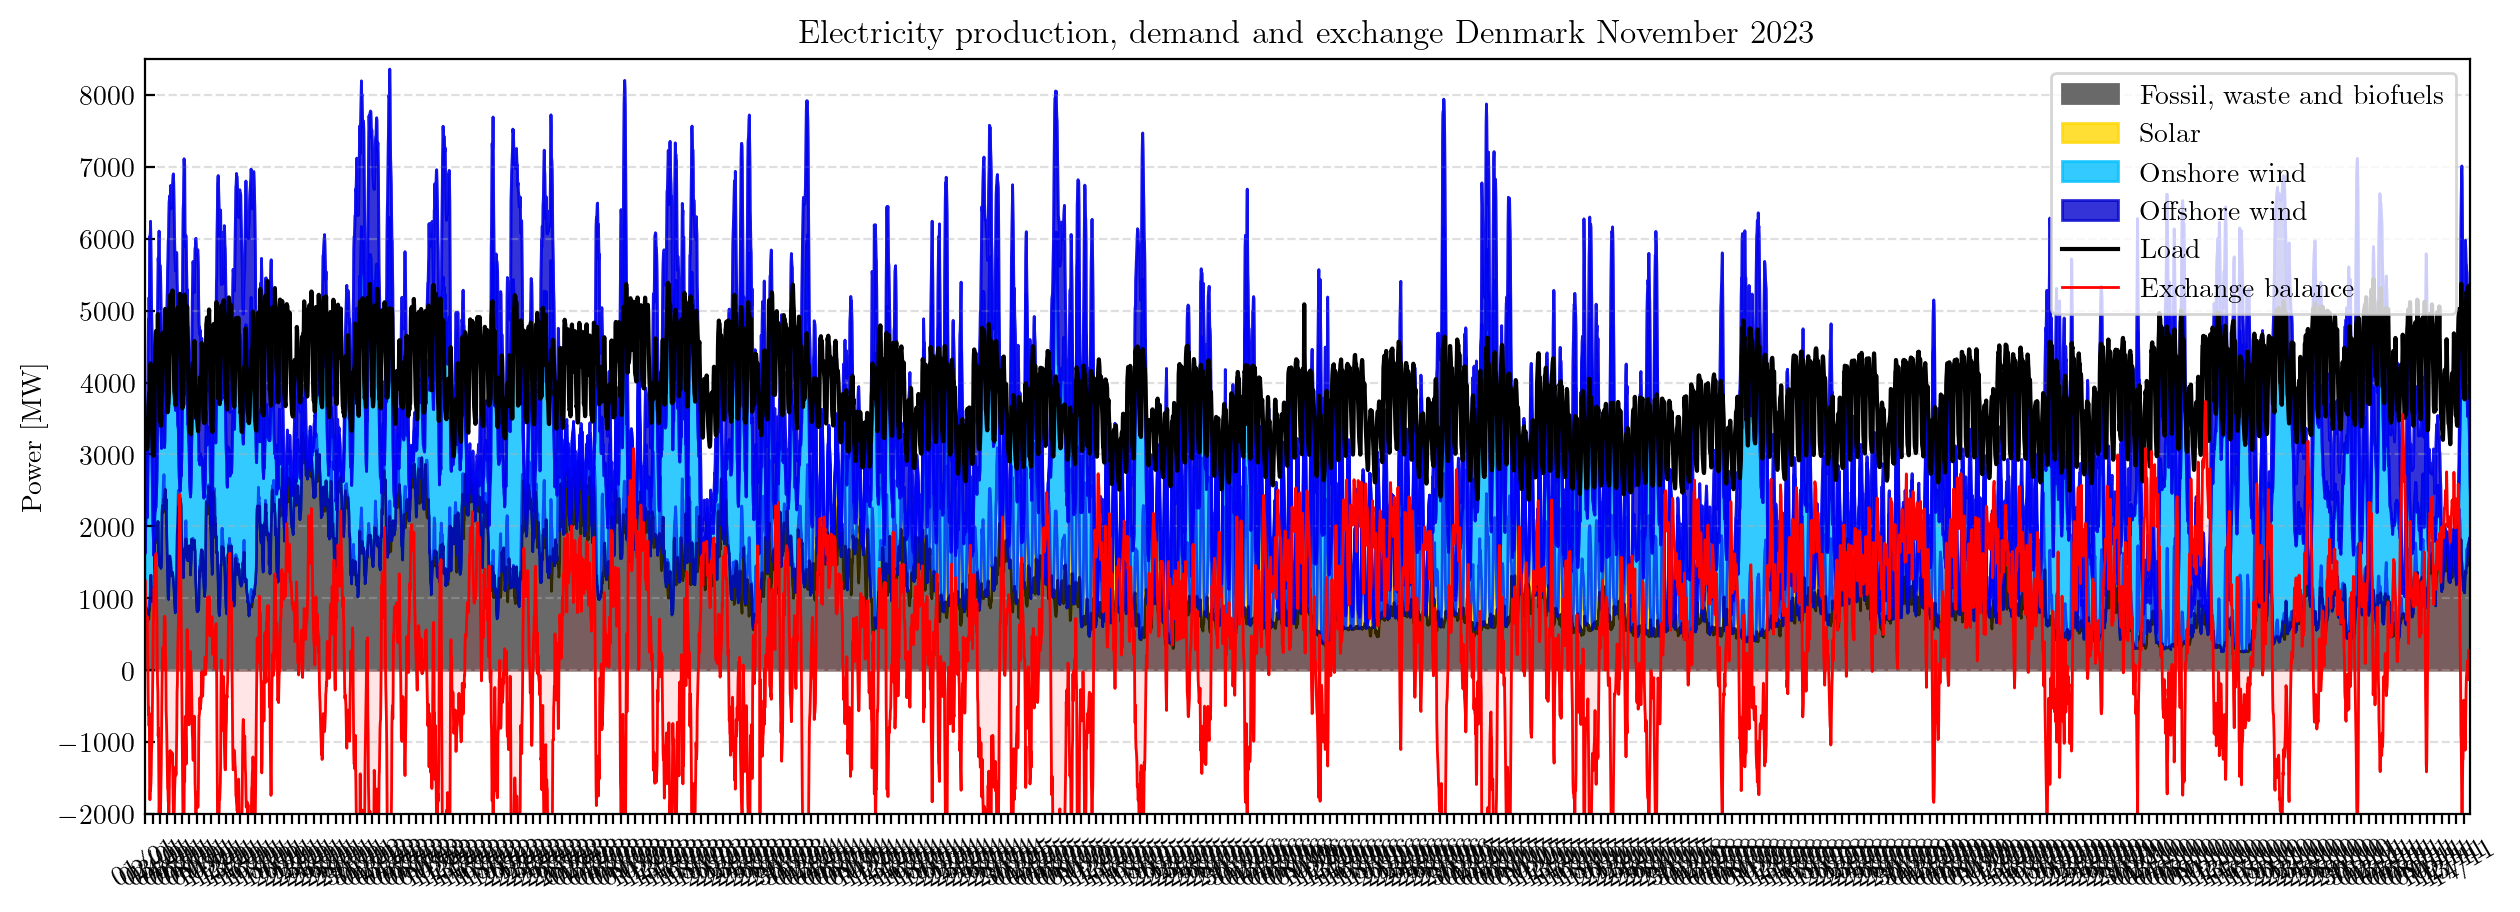

In [163]:
plt.figure(dpi=200,figsize=(15,5))

plt.plot(dates,fossil,color='black',linewidth=1,alpha=0.8)
plt.fill_between(dates,fossil,label='Fossil, waste and biofuels',color='dimgrey')
#plt.fill_between(dates,fossil+windsolar,fossil+windsolar+deficit_list,label='Deficit',color='yellowgreen',alpha=0.4)

plt.plot(dates,fossil+solar,color='blue',alpha=0.6,linewidth=1)
plt.fill_between(dates,fossil,solar+fossil,label='Solar',color='gold',alpha=0.8)

plt.plot(dates,fossil+solar+wind1,color='blue',alpha=0.6,linewidth=1)
plt.fill_between(dates,fossil+solar,fossil+solar+wind1,label='Onshore wind',color='deepskyblue',alpha=0.8)

plt.plot(dates,fossil+solar+wind1+wind2,color='blue',alpha=0.6,linewidth=1)
plt.fill_between(dates,fossil+solar+wind1,fossil+solar+wind1+wind2,label='Offshore wind',color='mediumblue',alpha=0.8)

plt.plot(dates,load,color='black',label='Load')

plt.plot(dates,import_eu+import_nordic,color='red',label='Exchange balance',linewidth=1)
plt.fill_between(dates,import_eu+import_nordic,color='red',linewidth=1,alpha=0.1)

plt.ylabel('Power [MW]')

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 30)

xs = []
i = 0
while i < z:
    xs.append(dates[i])
    i += 24
plt.xticks(xs)

ys = np.arange(-2000,26000,1000)
plt.yticks(ys)

plt.xlim(dates[0],dates[-1])
plt.ylim(-2000,8500)
plt.legend(loc='upper right')

plt.tick_params(axis='y',direction='in')#

plt.grid(axis='y',linestyle='--',alpha=0.4)

plt.title('Electricity production, demand and exchange Denmark November 2023')

#plt.savefig('excess.pdf')

Text(0.5, 1.0, 'Electricity generation Denmark 2023')

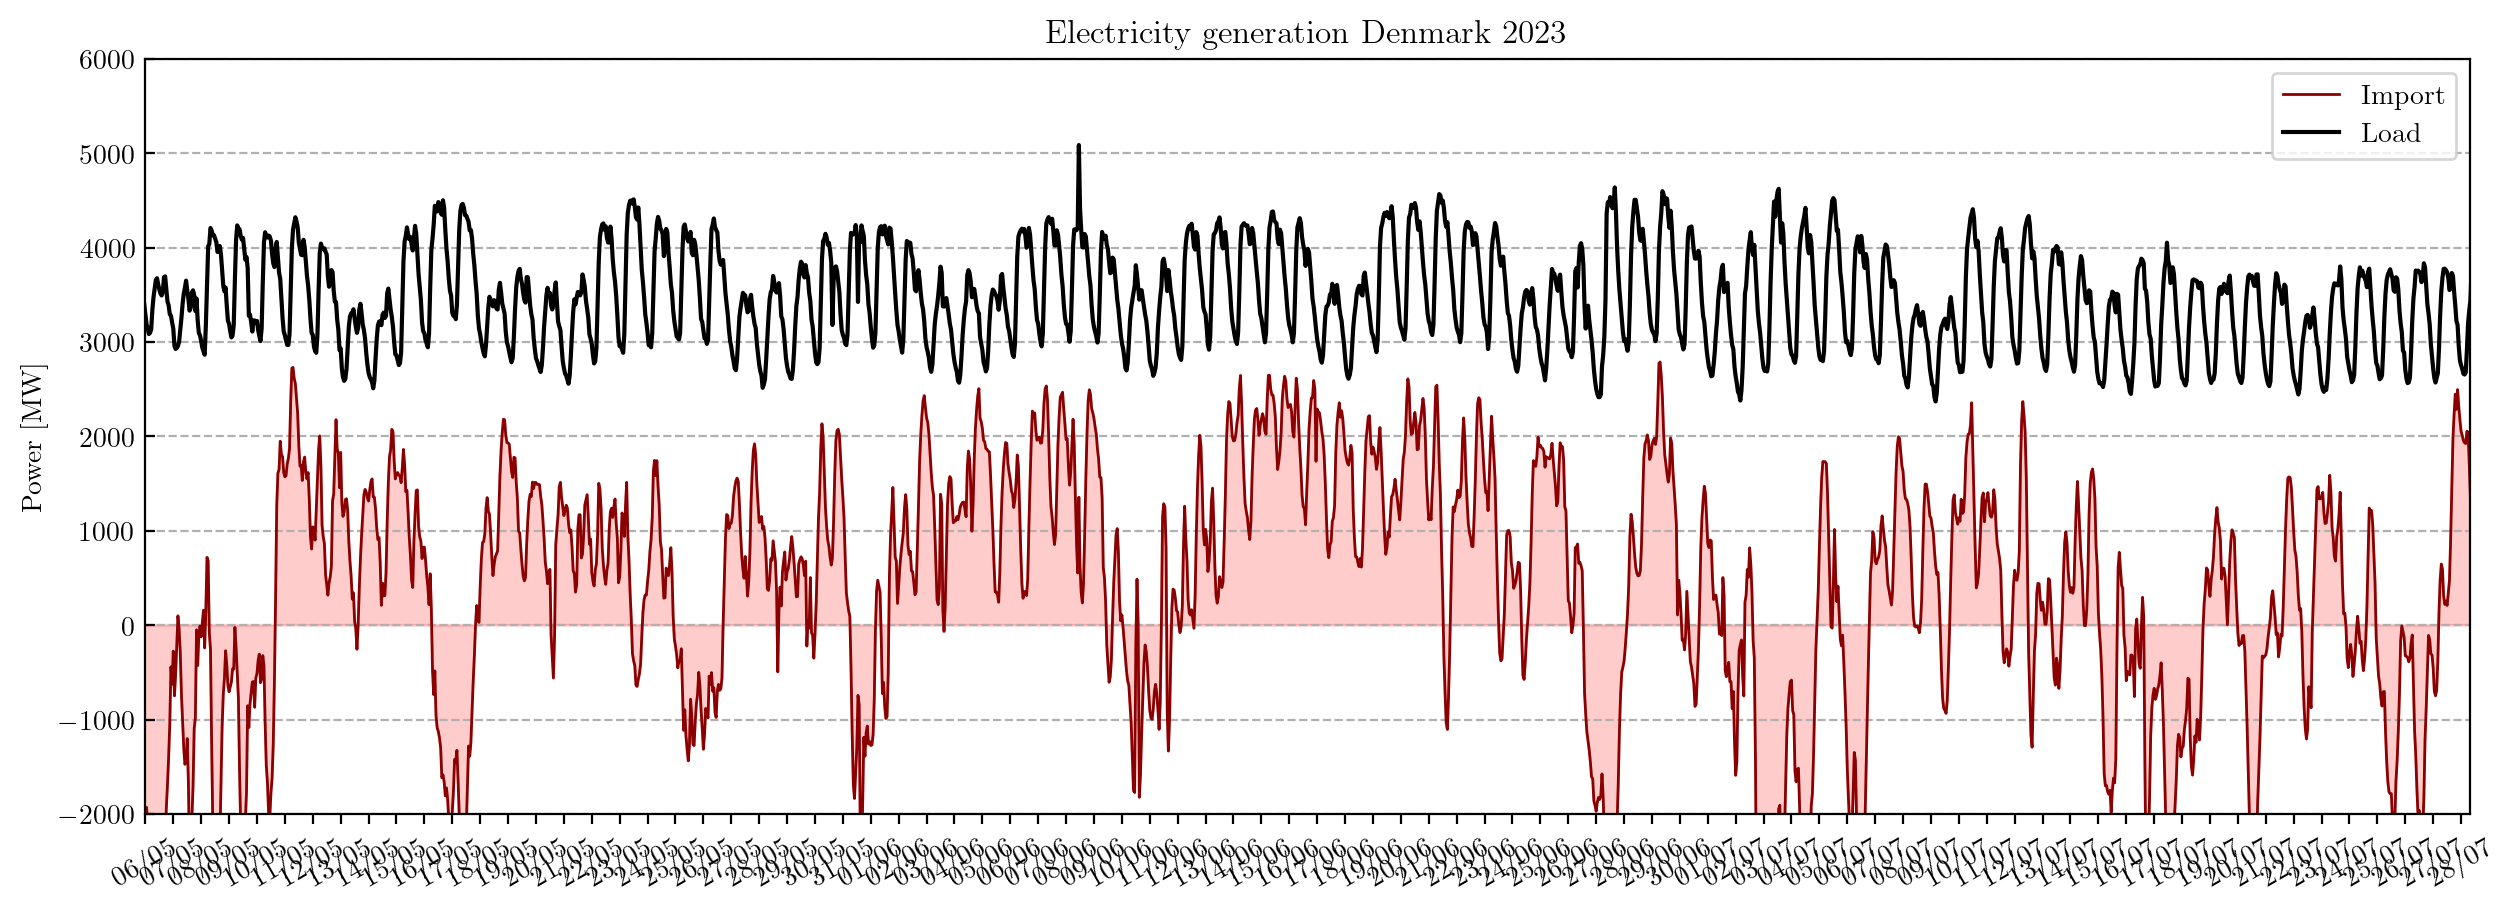

In [164]:
plt.figure(dpi=200,figsize=(15,5))

plt.plot(dates,import_eu+import_nordic,color='darkred',label='Import',linewidth=1)
plt.fill_between(dates,import_eu+import_nordic,color='red',linewidth=1,alpha=0.2)

plt.plot(dates,load,color='black',label='Load')

plt.ylabel('Power [MW]')

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 30)

xs = []
i = 0
while i < z:
    xs.append(dates[i])
    i += 24
plt.xticks(xs)

ys = np.arange(-2000,7000,1000)
plt.yticks(ys)

plt.xlim(dates[3000],dates[5000])
plt.ylim(-2000,6000)
plt.legend(loc='upper right')

plt.tick_params(axis='y',direction='in')#

plt.grid(axis='y',linestyle='--')

plt.title('Electricity generation Denmark 2023')

Text(0.5, 1.0, 'Import share of load in Denmark 2023')

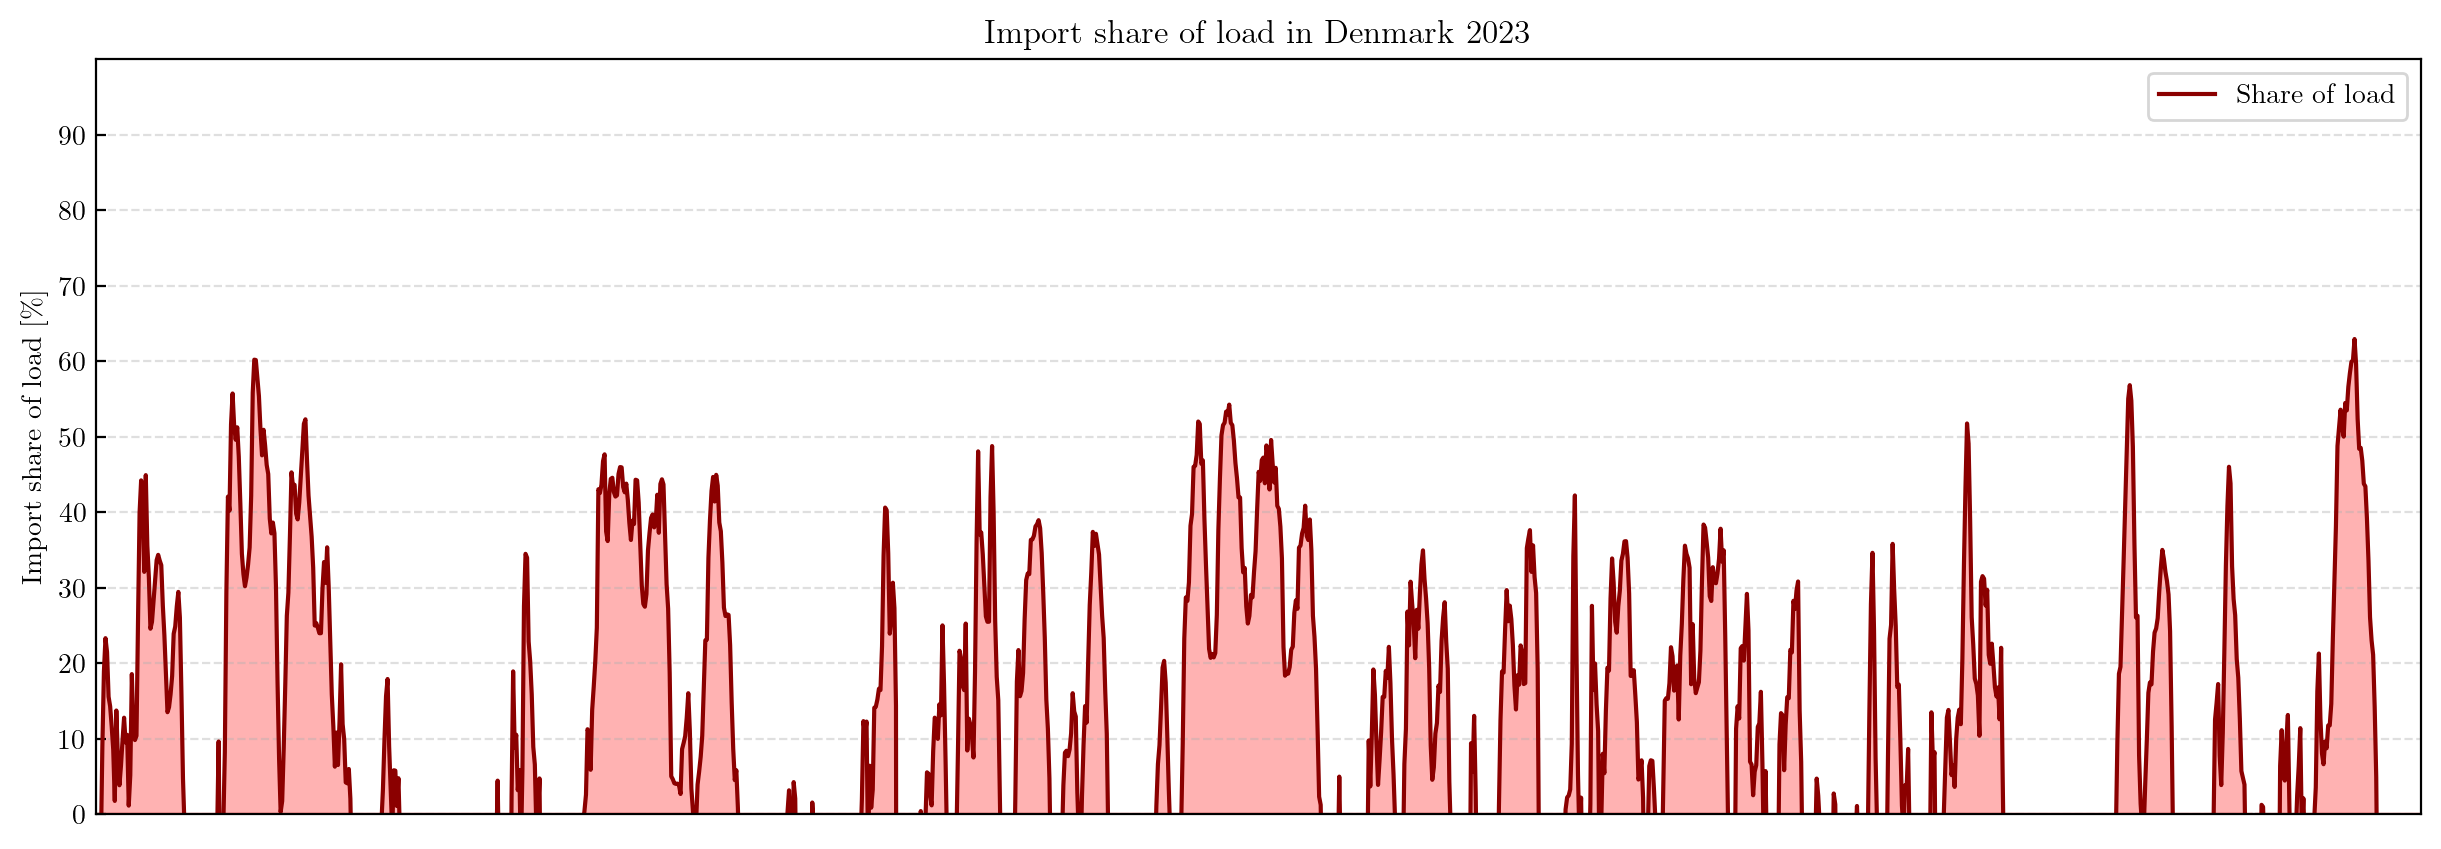

In [203]:
plt.figure(dpi=200,figsize=(15,5))

#plt.plot(dates,import_eu+import_nordic,color='red',label='Import',linewidth=1)
#plt.fill_between(dates,import_eu+import_nordic,color='red',linewidth=1,alpha=0.2)

import_share = import_total/load*100
plt.plot(dates,import_share,color='darkred',label='Share of load')
plt.fill_between(dates,import_share,color='red',alpha=0.3)

plt.ylabel('Import share of load [\%]')

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 30)

xs = []
i = 0
while i < z:
    xs.append(dates[i])
    i += 24
plt.xticks(xs)

ys = []
j = 0
while j < 100:
    ys.append(j)
    j += 10
plt.yticks(ys)

plt.xlim(dates[1500],dates[3000])
plt.ylim(0,100)
plt.legend(loc='upper right')

plt.tick_params(axis='y',direction='in')#

plt.grid(axis='y',linestyle='--',alpha=0.4)

plt.title('Import share of load in Denmark 2023')

#plt.savefig('Import-share.pdf')

In [205]:
max(import_share)


85.09138674698653

In [167]:
plt.figure(dpi=200,figsize=(14,6))
plt.plot(dates,import_total,color='red',label='Net import',linewidth=1)
plt.fill_between(dates,import_total,color='red',linewidth=1,alpha=0.2)
plt.ylabel('Power [MW]')

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 30)

xs = []
i = 0
while i < z:
    xs.append(dates[i])
    i += 96
plt.xticks(xs)

ys = np.arange(-3000,9000,1000)
plt.yticks(ys)
lim_a = 0
lim_b = -1
plt.xlim(dates[lim_a],dates[lim_b])
plt.ylim(-3300,4000)
plt.legend(loc='upper left')

plt.tick_params(axis='y',direction='in')

ax = plt.twinx()
ax.plot(dates,price,label='Spot price',color='black',linewidth=1)
ax.set_ylim(-10,300)
ax.set_ylabel('Spot price [EUR/MWh]')
ax.tick_params(axis='y',direction='in')
ax.legend(loc='upper right')
plt.grid(axis='y',linestyle='--')

plt.title('Import balance, October Denmark 2023')
#plt.savefig('import-and-price.pdf')
plt.close()

## CALCULATE PEARSON R

from scipy.stats import pearsonr
imports = np.nan_to_num(import_total)
pearson = pearsonr(imports[lim_a:lim_b],price[lim_a:lim_b])[0]
print(pearson)

0.4095525017858418


In [168]:
## MAKE LISTS OF NEGATIVE AND POSITIVE IMPORT VALUES
import_positive = []
for i in range(z):
    if import_total[i] > 0:
        import_positive.append(import_total[i])
    else:
        import_positive.append(0)

import_negative = []
for i in range(z):
    if import_total[i] < 0:
        import_negative.append(import_total[i])
    else:
        import_negative.append(0)

import_negative = np.array(import_negative)
import_positive = np.array(import_positive)
# Assuming you have two lists or arrays like this:
amounts = (-1)*import_negative
prices = price

# Create a pandas DataFrame from your arrays
data = pd.DataFrame({
    'Amount': amounts,
    'Price': prices
})

# Define price intervals (bins). Adjust these according to your specific needs
price_bins = [0, 20, 40, 60, 80, 100, 120, 140]  # for example

# Use the pd.cut function to categorize the data into bins
data['PriceInterval'] = pd.cut(data['Price'], bins=price_bins)

# Aggregate the data by summing the amounts within each price interval
grouped_data = data.groupby('PriceInterval').sum()

# Now plot the histogram
plt.figure(dpi=100,figsize=(8,8))
grouped_data['Amount'].plot(kind='bar')
plt.xlabel('Price Interval in €/MWh')
plt.ylabel('Total MWh Exported')
plt.title('Exported Electricity by Price Interval, October 2023 in Denmark')
plt.xticks(rotation = 35)
plt.savefig('Export-histogram.pdf')

# Create a pandas DataFrame from your arrays
data = pd.DataFrame({
    'Amount': amounts,
    'Price': prices
})

# Calculate total cost for each data point
data['TotalCost'] = data['Amount'] * data['Price']

# Calculate the sum of all total costs and the sum of all amounts
total_cost = data['TotalCost'].sum()
total_amount = data['Amount'].sum()

# Calculate the mean price per MWh
mean_price_per_mwh = total_cost / total_amount

print(f"The mean price per export MWh is: {mean_price_per_mwh}")
print(f'Total export is: {total_amount} MWh')
plt.close()

The mean price per export MWh is: 59.7704116735958
Total export is: 2912425.2288459996 MWh


In [169]:
## HISTOGRAM OF IMPORT AND PRICE

amounts = import_positive
prices = price

# Create a pandas DataFrame from your arrays
data = pd.DataFrame({
    'Amount': amounts,
    'Price': prices
})

# Define price intervals (bins). Adjust these according to your specific needs
price_bins = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220,240,260]  # for example

# Use the pd.cut function to categorize the data into bins
data['PriceInterval'] = pd.cut(data['Price'], bins=price_bins)

# Aggregate the data by summing the amounts within each price interval
grouped_data = data.groupby('PriceInterval').sum()

# Now plot the histogram
plt.figure(dpi=100,figsize=(8,8))
grouped_data['Amount'].plot(kind='bar')
plt.xlabel('Price Interval in €/MWh')
plt.ylabel('Total MWh Imported')
plt.title('Imported Electricity by Price Interval, October 2023 in Denmark')
plt.xticks(rotation = 35)
#plt.savefig('Import-histogram.pdf')
plt.close()
# Create a pandas DataFrame from your arrays
data = pd.DataFrame({
    'Amount': amounts,
    'Price': prices
})

# Calculate total cost for each data point
data['TotalCost'] = data['Amount'] * data['Price']

# Calculate the sum of all total costs and the sum of all amounts
total_cost = data['TotalCost'].sum()
total_amount = data['Amount'].sum()

# Calculate the mean price per MWh
mean_price_per_mwh = total_cost / total_amount

print(f"The mean price per imported MWh is: {mean_price_per_mwh}")
print(f'Total import is: {total_amount} MWh')

The mean price per imported MWh is: 108.23877326426366
Total import is: 5695456.403445 MWh


In [170]:
res = 0
nan = float('nan')
for e in import_total:
    if e > 0:
        res += e
print(res)
print(sum(deficit_list))

5695456.403445009
5326151.659589992


In [171]:
## TOTAL IMPORT PERCENTAGE
res/sum(load)

0.1944587663728012

In [172]:
## PLOT DIFFERENCE OF DEFICIT LIST AND POSITIVE IMPORT LIST
plt.figure(dpi=200,figsize=(14,6))
plt.plot(dates,import_total,color='red',label='Import balance',linewidth=1)
plt.plot(dates,deficit_list,color='violet',label='Deficit',linewidth=1)
plt.plot(dates,np.zeros(z),color='dimgrey',linewidth=1,linestyle='--')

plt.plot(dates,import_positive - deficit_list,color='dodgerblue',label='difference')
plt.ylabel('Power [MW]')

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 30)

xs = []
i = 0
while i < z:
    xs.append(dates[i])
    i += 192
plt.xticks(xs)

plt.xlim(dates[0],dates[-1])
plt.ylim(-2500,4000)

plt.legend()
plt.close()


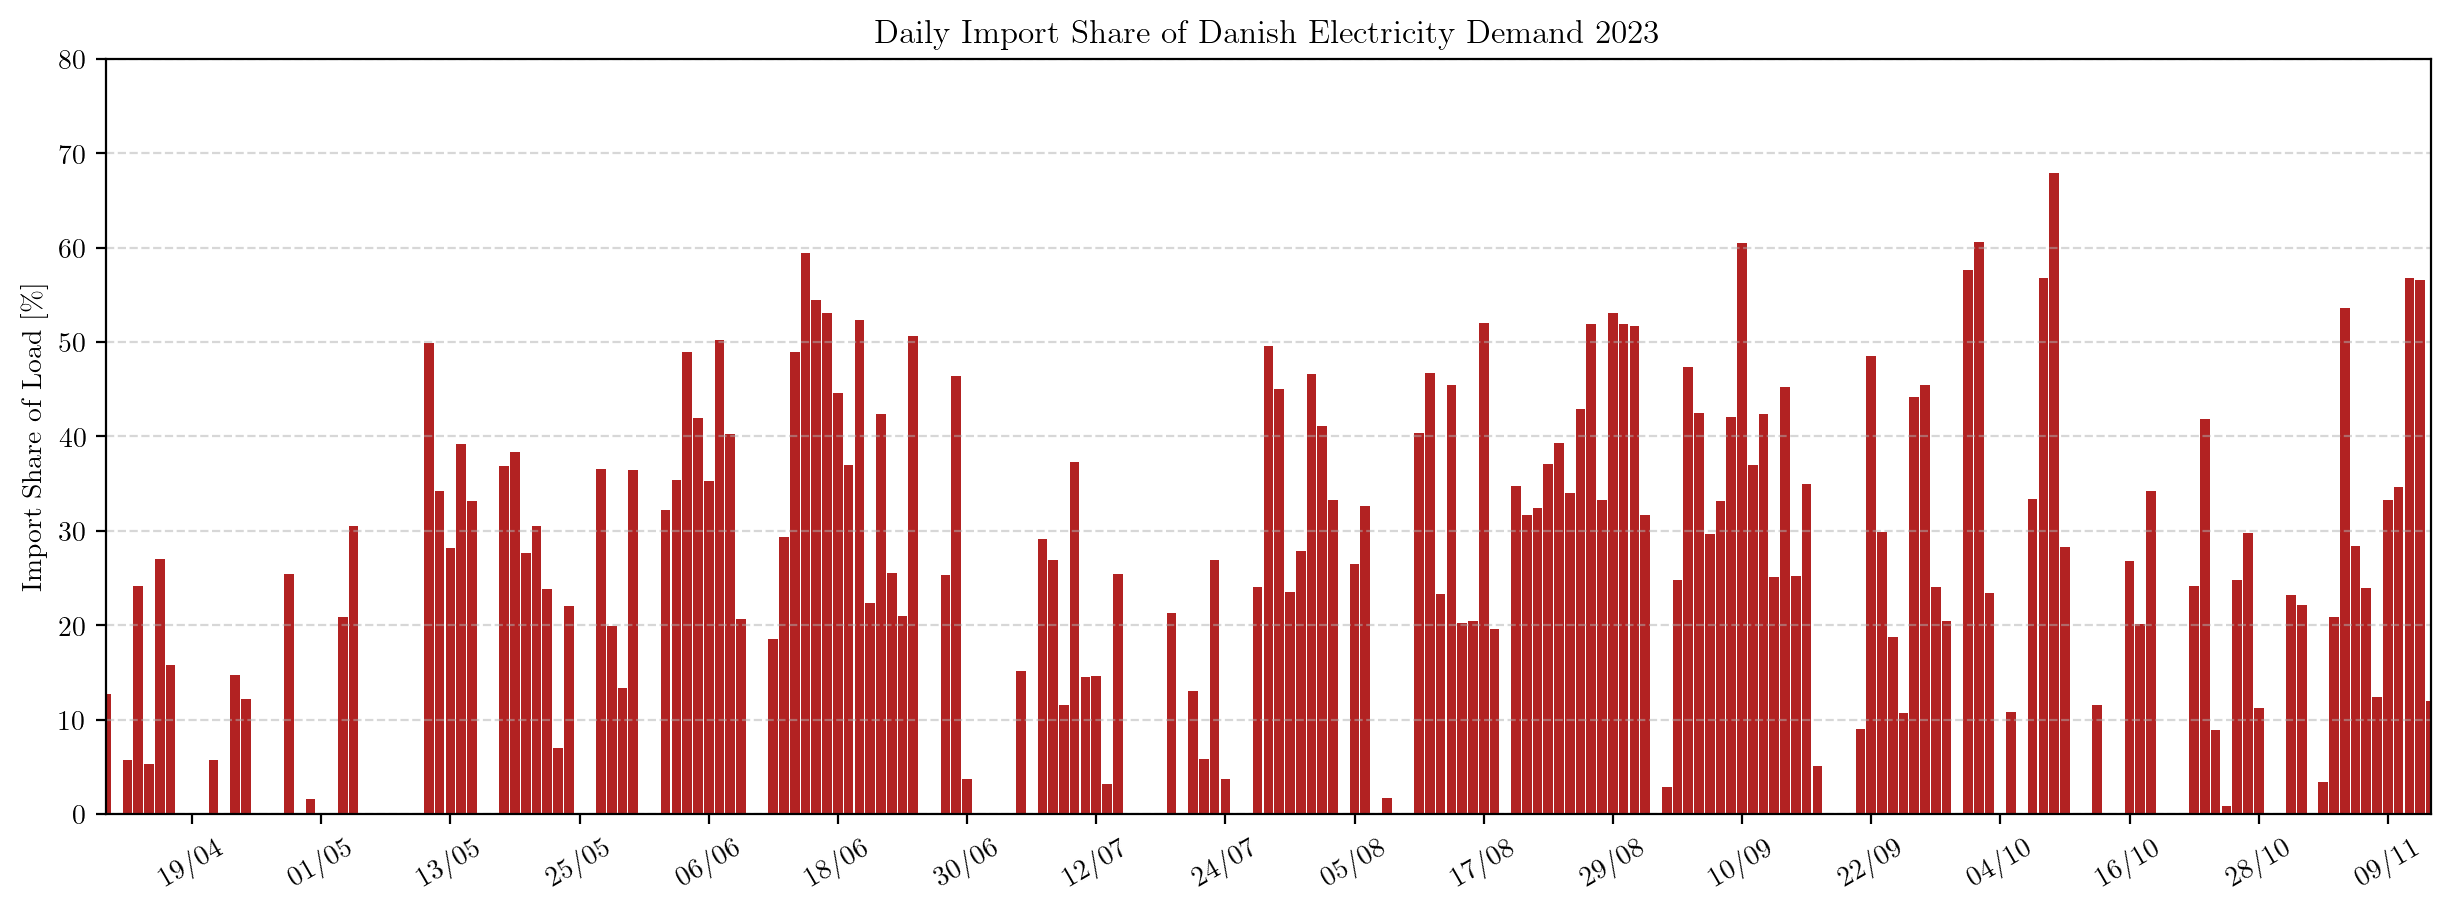

In [201]:
def average_list(a,x):
    '''Take the average of x next elements of a list
    Return: a numpy array'''
    new_list = []
    i = 0
    while i < len(a) - x:
        res = 0
        for j in range(x):
            res += a[i+j]
        new_list.append(res/x)
        i += x
    return np.array(new_list)

H = 24
avg_exchange = average_list(import_total,H)
avg_load = average_list(load,H)
avg_share = avg_exchange/avg_load*100
z = len(avg_load)
start = datetime.datetime(y1,1,1)
end = datetime.datetime(y2,11,15)
D = datetime.timedelta(hours=H)
datez = drange(start,end,D)
datez = datez[0:-1]
plt.figure(dpi=200,figsize=(15,5))
#plt.plot(dates, avg_exchange)
#plt.plot(dates,avg_load)
#plt.plot(datez,avg_load,color='black')
#plt.bar(datez,avg_exchange)
plt.bar(datez,avg_share,width=0.9,color='firebrick')
#plt.scatter(datez,avg_share,marker='.',color='black')
#plt.plot(datez,avg_share)

plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 30)

xz = []
i = 0
while i < z:
    xz.append(datez[i])
    i += 12
plt.xticks(xz)

yz = []
j = 0
while j < 100:
    yz.append(j)
    j += 10
plt.yticks(yz)
plt.ylim(0,80)

plt.grid(axis='y',linestyle='--',alpha=0.5)

plt.xlim(datez[100],datez[-1])

plt.title('Daily Import Share of Danish Electricity Demand 2023')
plt.ylabel('Import Share of Load [\%]')

plt.savefig('Daily-importshare.pdf')
#plt.show()

In [176]:
positive_import = []
for i in import_total:
    if i > 0:
        positive_import.append(i)

sum_import_positive = sum(positive_import)
sum_import_positive/sum(load)

0.1944587663728012